# i3a  -  Clase 5
# Índice
1. [Autoencoders](#ae)
    1. [MNIST](#mnist)
        3. [Dense](#dense)
        2. [Convolucional](#conv)
    1. [Audio](#audio)

In [2]:
%matplotlib inline
import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import matplotlib.pyplot as plt
from keras.utils.vis_utils import model_to_dot, plot_model

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.initializers import RandomNormal
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras import regularizers
from keras.datasets import mnist
import keras as keras
import tensorflow as tf

from IPython.display import Image, Audio
from scipy.interpolate import interp1d
from sklearn.manifold import TSNE

import glob
from utils import mosaic

plt.rcParams['font.size']=20
plt.rcParams['figure.figsize']=(8,6)

In [3]:
#en colab
#!wget https://gitlab.com/i3a/clases/raw/master/utils.py -O utils.py
from utils import mosaic

# Autoencoders <a name="ae"></a>

![](https://www.curiousily.com/media/data-imputation-2/mushroom_encoder.png)


Encoder

$Z = f(X)$

Z = Espacio Latente

Decoder

$X = f^{-1}(Z)$


## MNIST <a name="mnist"></a>

In [35]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Autoencoder de una capa sola

In [4]:
encoding_dim = 32 

# Input
input_img = Input(shape=(784,))
# Capa encoded
encoded = Dense(encoding_dim, activation='relu')(input_img)
# Capa decoded final 
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

# Modelo auxiliar que va hasta encoded
encoder = Model(input_img, encoded)

# Modelo auxiliar que va de encoded hasta el final
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

h = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

plt.semilogy(h.history['loss'], label='Train Loss')
plt.semilogy(h.history['val_loss'], label = 'Val Loss');
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.legend()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.3571 - val_loss: 0.2711
Epoch 2/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.2640 - val_loss: 0.2531
Epoch 3/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.2428 - val_loss: 0.2303
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2224 - val_loss: 0.2125
Epoch 5/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2074 - val_loss: 0.2000
Epoch 6/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.1962 - val_loss: 0.1898
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1872 - val_loss: 0.1819
Epoch 8/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.1800 - val_los

KeyboardInterrupt: 

In [ ]:
# Usamos las funciones auxiliares para encodear y decodear los datos de test
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Visualicemos N imágenes originales y reconstruidas
N = 30
plt.figure(figsize=(10,4))
imgs = x_test[:N].reshape(N,28,28)
plt.imshow(mosaic(imgs,10),cmap=plt.cm.gray)
plt.axis('off')
plt.figure(figsize=(10,4))
imgs = decoded_imgs[:N].reshape(N,28,28)
plt.imshow(mosaic(imgs,10),cmap=plt.cm.gray)
plt.axis('off');

## Espacio Latente

#### Vemos el output prendiendo una por una las neuronas del espacio latente

In [ ]:
Z = np.diag(np.ones(encoding_dim))*5
display(Z)
decoded_imgs = decoder.predict(Z)
imgs = decoded_imgs.reshape(encoding_dim,28,28)
plt.figure(figsize=(10,4))
plt.imshow(mosaic(imgs,8),cmap=plt.cm.gray)
plt.axis('off');

#### Prendemos paulatinamente una neurona

In [ ]:
N = 30
U = 5
Z = np.zeros((encoding_dim,N))
Z[U,:] = np.logspace(0,1,N)
Z = Z.T
decoded_imgs = decoder.predict(Z)
imgs = decoded_imgs.reshape(N,28,28)
plt.figure(figsize=(10,4))
plt.imshow(mosaic(imgs,10),cmap=plt.cm.gray)
plt.axis('off');

#### Generamos puntos random en el espacio latente

In [ ]:
N = 30
decoded_imgs = decoder.predict(np.random.rand(N,32))
imgs = decoded_imgs.reshape(N,28,28)
plt.figure(figsize=(10,4))
plt.imshow(mosaic(imgs,10),cmap=plt.cm.gray)
plt.axis('off');

#### Interpolación enter dos puntos del dataset

In [ ]:
N = 30
encoded_imgs = encoder.predict(x_test)
linfit = interp1d([0,1], np.vstack([encoded_imgs[0], encoded_imgs[3]]), axis=0)
Z = linfit(np.linspace(0,1,N))
decoded_imgs = decoder.predict(Z)
imgs = decoded_imgs.reshape(N,28,28)
plt.figure(figsize=(10,4))
plt.imshow(mosaic(imgs,10),cmap=plt.cm.gray)
plt.axis('off');

#### Visualicemos el espacio latente con TSNE

In [ ]:
encoded_imgs = encoder.predict(x_test)[:1000]
tsne = TSNE(n_components=2)
data2d = tsne.fit_transform(encoded_imgs)
plt.scatter(data2d[:,0],data2d[:,1],c=y_test[:1000],cmap=plt.cm.get_cmap('tab10', 10),vmin=-0.5,vmax=9.5)
plt.colorbar(ticks=np.arange(10));

Cuello de botella 128


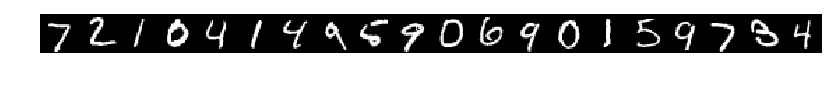

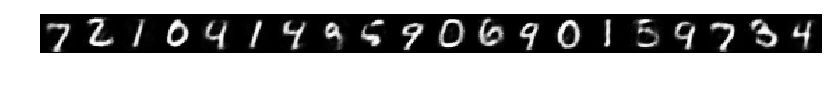

Cuello de botella 64


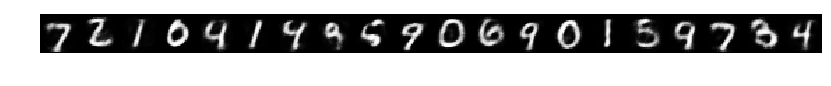

Cuello de botella 32


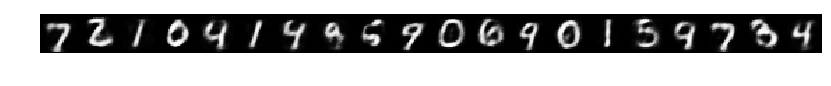

Cuello de botella 16


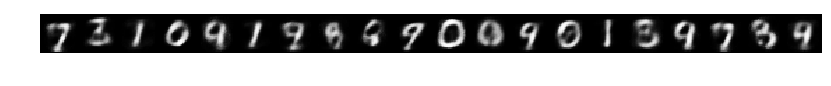

Cuello de botella 8


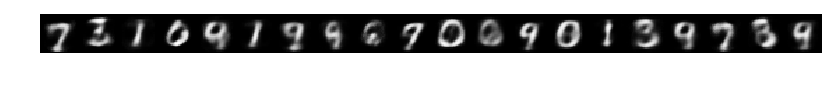

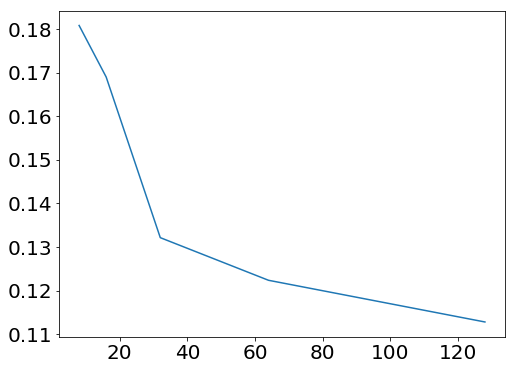

In [36]:
N = 20
plt.figure(figsize=(14,8))
imgs = x_test[:N].reshape(N,28,28)
plt.imshow(mosaic(imgs,20),cmap=plt.cm.gray)
plt.axis('off')

encoding_dims = [128,64,32,16,8]
mses = []
for encoding_dim in encoding_dims:
    print('Cuello de botella', encoding_dim)
    input_img = Input(shape=(784,))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    h = autoencoder.fit(x_train, x_train,
                    epochs=20,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test), verbose=0)
    
    mse = autoencoder.evaluate(x_test,x_test,verbose=0)
    mses.append(mse)
    
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    plt.figure(figsize=(14,8))
    imgs = decoded_imgs[:N].reshape(N,28,28)
    plt.imshow(mosaic(imgs,20),cmap=plt.cm.gray)
    plt.axis('off');
    plt.show()

plt.figure()
plt.plot(encoding_dims,mses)

# Autoencoder Convolucional

#### Cargamos MNIST sin reshape

In [37]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [85]:
input_img = Input(shape=(28, 28, 1))


x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
print('Shape',x.shape.as_list())
encoded_shape = x.shape.as_list()[1:]
encoding_dim = np.prod(encoded_shape)
x = Flatten()(x)
x = Reshape(encoded_shape)(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

opt = Adam(0.001)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

# Modelo auxiliar
# encoder = Model(input_img, encoded)
# encoded_input = Input(shape=(encoding_dim,1,1,1))
# decoder = Model(encoded_input, encoder(encoded_input))

autoencoder.summary()

Shape [None, 4, 4, 8]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_274 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_275 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_276 (Conv2D)          (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 4, 4, 8)          

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 94us/step - loss: 0.1221 - val_loss: 0.1176
Epoch 2/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.1172 - val_loss: 0.1140
Epoch 3/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.1142 - val_loss: 0.1115
Epoch 4/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.1119 - val_loss: 0.1098
Epoch 5/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.1100 - val_loss: 0.1080
Epoch 6/20
60000/60000 [==============================] - 6s 99us/step - loss: 0.1084 - val_loss: 0.1077
Epoch 7/20
60000/60000 [==============================] - 6s 100us/step - loss: 0.1071 - val_loss: 0.1054
Epoch 8/20
60000/60000 [==============================] - 6s 102us/step - loss: 0.1060 - val_loss: 0.1047
Epoch 9/20
60000/60000 [==============================] - 6s 97us/step - loss: 0.1051 - val_loss: 0.1033

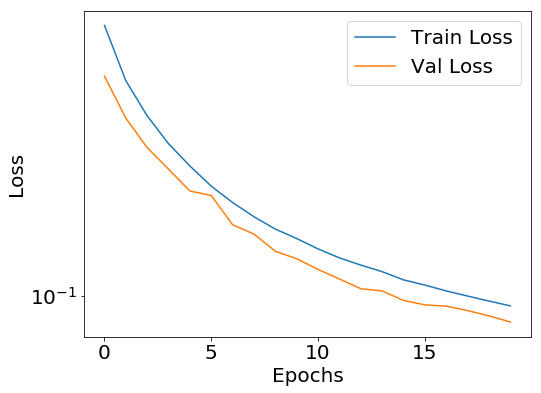

In [97]:
h = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

plt.semilogy(h.history['loss'], label='Train Loss')
plt.semilogy(h.history['val_loss'], label = 'Val Loss');
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.legend()

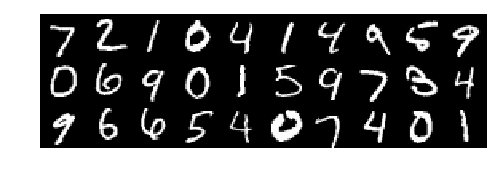

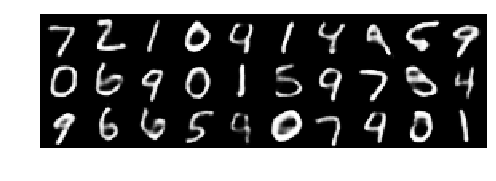

In [98]:
N = 30
decoded_imgs = autoencoder.predict(x_test)

imgs = x_test[:N].reshape(N,28,28)
plt.imshow(mosaic(imgs,10),cmap=plt.cm.gray)
plt.axis('off')
plt.figure()
imgs = decoded_imgs[:N].reshape(N,28,28)
plt.imshow(mosaic(imgs,10),cmap=plt.cm.gray)
plt.axis('off');

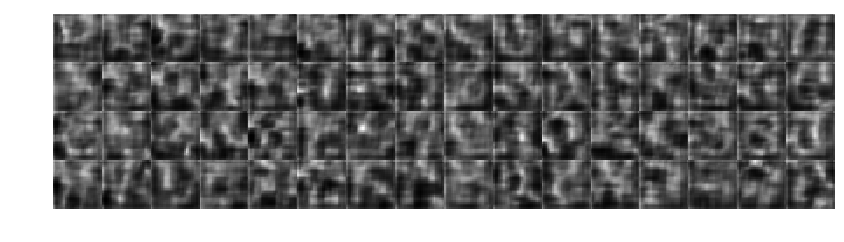

In [152]:
decoder = K.function([autoencoder.layers[8].input],[autoencoder.layers[-1].output])
Z = np.diag(np.ones(encoding_dim))*5
Z = np.random.rand(64,encoding_dim)*0.2
decoded_imgs = decoder([Z])[0]
plt.figure(figsize=(14,14))
plt.imshow(mosaic(decoded_imgs[:,:,:,0],16),cmap=plt.cm.gray)
plt.axis('off');

## Audio
#### Para trabajar con audio vamos a leer muchos archivos wav y calcular el espectrograma. El espectrograma se pasa valor absoluto, decibeles y se normaliza.

In [ ]:
!wget https://www.dropbox.com/s/5f6gkno8l69xj8w/moog.zip?dl=0 -O moog.zip
!mkdir datasets
!mkdir datasets/wavs
!unzip -o moog.zip -d datasets/wavs

In [68]:
Sclip = -60
hop_length_ms = 5
win_length_ms = 20
X = []
y = []
phases = []
path = 'datasets/wavs/moog/*.wav'
# path = 'datasets/fonemas-wav/*'
for i,filename in enumerate(glob.glob(path)):
#     print(filename)
    x,sr = librosa.load(filename, sr=16000, mono=True)
    x = np.trim_zeros(x)
    win_length = int(win_length_ms/1000*sr)
    hop_length = int(hop_length_ms/1000*sr)
    F = librosa.stft(x,n_fft=win_length, hop_length=hop_length).T
    phases.append(np.angle(F))
    S = 10*np.log10(np.abs(F)**2)
    S = S.clip(Sclip, None)-Sclip
    y.append(np.ones(S.shape[0])*i)
    X.append(S)
    
phases = np.vstack(phases)    
X = np.vstack(X)
Xmax = X.max()
X = X/Xmax
y = np.hstack(y)

datasets/wavs/moog/SYNTH-SimpleTuna1.wav
datasets/wavs/moog/SYNTH-PhanaLox2.wav
datasets/wavs/moog/BASS-SharpyAcidoBass2.wav
datasets/wavs/moog/SYNTH-Gherkin2.wav
datasets/wavs/moog/SYNTH-BeautyBellioLow.wav
datasets/wavs/moog/SYNTH-SensualChurchBell.wav
datasets/wavs/moog/SYNTH-BeautyBellioX.wav
datasets/wavs/moog/SYNTH-MiniMoogStab1.wav
datasets/wavs/moog/SYNTH-Cheesewizz.wav
datasets/wavs/moog/SYNTH-Fogonome2.wav
datasets/wavs/moog/SYNTH-CheesewizzSlowAttack.wav
datasets/wavs/moog/BASS-MicroFriebel3.wav
datasets/wavs/moog/SYNTH-SmeerVCO.wav
datasets/wavs/moog/BASS-Chokotofat2.wav
datasets/wavs/moog/SYNTH-SimpleWave2.wav
datasets/wavs/moog/BASS-Mudsy.wav
datasets/wavs/moog/SYNTH-DeeperFilteredFogonome.wav
datasets/wavs/moog/SYNTH-PhanaLox1.wav
datasets/wavs/moog/SYNTH-Gherkin3.wav
datasets/wavs/moog/WEIRD-ResonanceZone.wav
datasets/wavs/moog/SYNTH-Brilliance.wav
datasets/wavs/moog/SYNTH-RomanticMoog2.wav
datasets/wavs/moog/SYNTH-SimpleWave1.wav
datasets/wavs/moog/SYNTH-BeautyBellio3.

/home/miles/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


datasets/wavs/moog/SYNTH-Grizzly3.wav
datasets/wavs/moog/SYNTH-PhanaLox3.wav
datasets/wavs/moog/FX-Twoipinio.wav
datasets/wavs/moog/SYNTH-Metaly.wav
datasets/wavs/moog/SYNTH-CriminalOlive.wav
datasets/wavs/moog/SYNTH-SimpleTuna5.wav
datasets/wavs/moog/SYNTH-Sweepbweep2.wav
datasets/wavs/moog/BASS-Dogbass.wav
datasets/wavs/moog/SYNTH-KabeljauwSynthie2.wav
datasets/wavs/moog/SYNTH-BeautyBellioLower.wav
datasets/wavs/moog/BASS-SapWapFuzzzzzzzzz.wav
datasets/wavs/moog/SYNTH-Fogonome1.wav
datasets/wavs/moog/CHORDPAD-DuneValley-WithThunder.wav
datasets/wavs/moog/SYNTH-MiniMoogStab2.wav
datasets/wavs/moog/SYNTH-Tweekie7Squared.wav
datasets/wavs/moog/WEIRD-RadioSalamander.wav
datasets/wavs/moog/SYNTH-HauntedChurchBell.wav
datasets/wavs/moog/BASS-MicroFriebel.wav
datasets/wavs/moog/SYNTH-Smurmoz1.wav
datasets/wavs/moog/BASS-SoftSubVelvet.wav
datasets/wavs/moog/SYNTH-Silverbird3.wav
datasets/wavs/moog/SYNTH-Monsiour3egelwinter.wav
datasets/wavs/moog/BASS-SharpyAcidoBass3.wav
datasets/wavs/moog/F

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [5]:
print('Win length:',win_length,', Hop length:', hop_length)
print('Data shape:',X.shape)
print('Length mind:',X.shape[0]*hop_length_ms/1000/60)
n_features = X.shape[1]

Win length: 320 , Hop length: 80
Data shape: (286999, 161)
Length mind: 23.91658333333333


In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,  test_size=0.80, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.90, shuffle=False)
print('Length mins:',X_train.shape[0]*hop_length_ms/1000/60)

Length mins: 4.78325


#### Visuzalición del data set de train

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.specshow(X_train.T,y_axis='linear',x_axis='time',hop_length=hop_length);

#### Escuchamos como se reconstruye el audio previo a hacer el autoencoder. Para eso hay que inventar una fase, en este caso es random.

In [ ]:
phase = phases[:X_train.shape[0]]
X_ = np.sqrt(10**((X_train*Xmax+Sclip)/10))*np.exp(1j*phase)
x_ = librosa.istft(X_.T,hop_length=hop_length, win_length=win_length)

plt.plot(x_)
display('Fase original')
display(Audio(x_,rate=sr))

phase = np.random.rand(*X_train.shape)*2*np.pi
X_ = np.sqrt(10**((X_train*Xmax+Sclip)/10))*np.exp(1j*phase)
x_ = librosa.istft(X_.T,hop_length=hop_length, win_length=win_length)

display('Fase random')
display(Audio(x_,rate=sr))

### Armamos un autoencoder denso de 8 capas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 161)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 64)                10368     
_________________________________________________________________
dense_44 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_45 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_48 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                2112      
__________

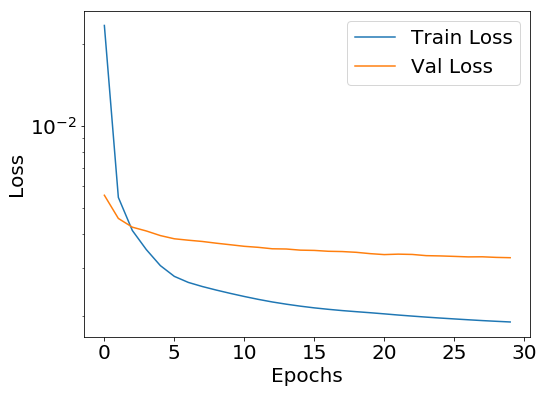

In [94]:
encoding_dim = 8
input_fft = Input(shape=(n_features,))
encoded = Dense(64, activation='relu')(input_fft)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(n_features, activation='linear')(decoded)
autoencoder = Model(input_fft, decoded)

encoder = Model(input_fft, encoded)
encoded_input = Input(shape=(encoding_dim,))

opt = Adam(0.0001)
autoencoder.compile(optimizer=opt, loss='mse')
print(autoencoder.summary())
h = autoencoder.fit(X_train, X_train,
                epochs=30,
                batch_size=64,
                shuffle=True, validation_data= (X_val,X_val))

plt.semilogy(h.history['loss'], label='Train Loss')
plt.semilogy(h.history['val_loss'], label = 'Val Loss');
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.legend();

#### Podemos escuchar la reconstrucción, primero con la fase original

In [ ]:
Y = autoencoder.predict(X_train)
Y = Y-np.min(Y)
plt.figure(figsize=(14,4))
librosa.display.specshow(Y.T,y_axis='linear',x_axis='time',hop_length=hop_length);

phase = phases[:X_train.shape[0]]
Y_ = np.sqrt(10**((Y*Xmax+Sclip)/10))*np.exp(1j*phase)
y_ = librosa.istft(Y_.T,hop_length=hop_length, win_length=win_length)

display('Fase original')
display(Audio(y_,rate=sr))

phase = np.random.rand(*Y.shape)*2*np.pi
Y_ = np.sqrt(10**((Y*Xmax+Sclip)/10))*np.exp(1j*phase)
y_ = librosa.istft(Y_.T,hop_length=hop_length, win_length=win_length)

display('Fase random')
display(Audio(y_,rate=sr))

#### Veamos la actividad en la capa del medio

In [ ]:
Z = encoder.predict(X_val)
plt.figure(figsize=(14,6))
plt.plot(Z+np.arange(Z.shape[1])*5);

#### Sinteticemos audio generando trayectorias en el espacio latente

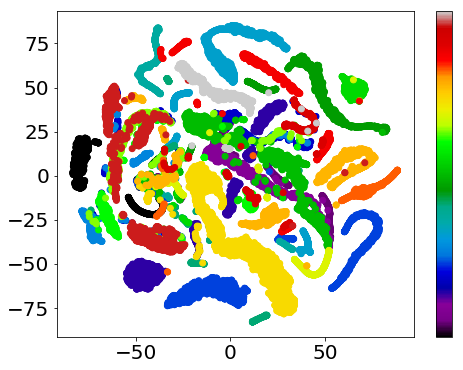

In [81]:
Z = encoder.predict(X_val)
tsne = TSNE(n_components=2)
data2d = tsne.fit_transform(Z)
plt.scatter(data2d[:,0],data2d[:,1],c=y_val,cmap=plt.cm.nipy_spectral)

In [ ]:
T = 0.5
T_frames = int(T*sr/hop_length)
decode = K.function([autoencoder.layers[5].input], [autoencoder.layers[-1].output])

N = 60
Z = []
for i in range(N):
    z = np.random.rand(encoding_dim)*1.0
    linfit = interp1d([0,1], [z,np.zeros(encoding_dim)], axis=0, kind='linear')
    z = linfit(np.linspace(0,1,T_frames))
    Z.append(z)
Z = np.vstack(Z)
Y = decode([Z])[0]

Y = Y-np.min(Y)
plt.figure(figsize=(14,4))
librosa.display.specshow(Y.T,y_axis='linear',x_axis='time',hop_length=hop_length);

phase = np.random.rand(*Y.shape)*2*np.pi
# phase = np.zeros(Y.shape)
Y_ = np.sqrt(10**((Y*Xmax+Sclip)/10))*np.exp(1j*phase)
y_ = librosa.istft(Y_.T,hop_length=hop_length, win_length=win_length)
plt.figure(figsize=(14,4))

plt.plot(y_)
Audio(y_,rate=sr)

In [160]:
path = 'datasets/wavs/Milonga_del_bicho_feo.wav'
for i,filename in enumerate(glob.glob(path)):
#     print(filename)
    x,sr = librosa.load(filename, sr=16000, mono=True, duration=60)
    x = np.trim_zeros(x)
    win_length = int(win_length_ms/1000*sr)
    hop_length = int(hop_length_ms/1000*sr)
    F = librosa.stft(x,n_fft=win_length, hop_length=hop_length).T
    phase_ = np.angle(F)
    S = 10*np.log10(np.abs(F)**2)
    S = S.clip(Sclip, None)-Sclip

In [ ]:
Y = autoencoder.predict(S)
Y = Y-np.min(Y)
plt.figure(figsize=(14,4))
librosa.display.specshow(Y.T,y_axis='linear',x_axis='time',hop_length=hop_length);

scale = 1e-3
Y_ = np.sqrt(10**((Y*Xmax+Sclip)/10*scale))*np.exp(1j*phase_)
print(np.max(np.abs(Y_)))
y_ = librosa.istft(Y_.T,hop_length=hop_length, win_length=win_length)

display('Fase original')
display(Audio(y_,rate=sr))

phase = np.random.rand(*Y.shape)*2*np.pi
Y_ = np.sqrt(10**((Y*Xmax+Sclip)/10*scale))*np.exp(1j*phase)
y_ = librosa.istft(Y_.T,hop_length=hop_length, win_length=win_length)

display('Fase random')
display(Audio(y_,rate=sr))

In [162]:
autoencoder.save('ae.pickle')